In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import random
import matplotlib.pyplot as plt

from keras import models
from keras import layers
from keras.optimizers.legacy import RMSprop
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In this notebook we train the Neural Network models. Similar to the SVM notebook, we first tune the network architecture and hyperparameters for the hexagon resolution 6 and time resolution 4 hours. Then we use the found hyperparameters to train models with other spatio-temporal resolutions

## Define Functions for training Neural Network

In [2]:
def scale_data_and_get_dummies(data, location_bucket):
    # scale data except location bucket and demand
    col_scale_list = data.columns.to_list()
    col_scale_list.remove(location_bucket)
    col_scale_list.remove("demand")
    scaler = StandardScaler()
    data[col_scale_list] = scaler.fit_transform(data[col_scale_list])
    # create one hot encoding for location bucket feature
    data = pd.get_dummies(data, columns=[location_bucket], dtype=int)
    return data

def split_train_test(data, target_col="demand"):
    # split data into train and test
    X = data.drop(columns=[target_col])
    y = data[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4711)
    return X_train, X_test, y_train, y_test 

In [3]:
def build_model(X_train, layer_nodes = [64, 64], learning_rate=0.001, dropout=0, activation = 'relu', optimizer = RMSprop):
    model = models.Sequential()
    model.add(layers.Dense(layer_nodes[0], activation=activation, input_shape=(X_train.shape[1],)))
    if len(layer_nodes) > 1:
        for nodes in layer_nodes[1:]:
            model.add(layers.Dense(nodes, activation=activation))
            if dropout >= 0:
                model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='relu'))

    opt = optimizer(lr=learning_rate)
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    return model

hyperparameters_default = {
    'layer_nodes': [64, 64],
    'learning_rate': 0.001,
    'dropout': 0,
    'activation': 'relu',
    'optimizer': RMSprop
}

def k_fold_nn(
        X_train, 
        y_train, 
        k=4, 
        epochs=50, 
        batch_size=1, 
        verbose=0,
        hyperparams=hyperparameters_default
        ):
    num_val_samples = len(X_train) // k
    num_epochs = epochs
    all_scores_mae = []
    all_scores_mse = []
    all_mae_histories = []
    all_mse_histories = []

    for i in range(k):
        print('processing fold #', i, " of ", k)
        val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]    # Slice Get Validation Data 
        val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples] # Slice Val. Target Data

        # Exclude validation data from the training data
        partial_train_data = np.concatenate(
            [
                X_train[:i * num_val_samples],
                X_train[(i + 1) * num_val_samples:]
            ],
            axis=0)
        partial_train_targets = np.concatenate(
            [
                y_train[:i * num_val_samples],
                y_train[(i + 1) * num_val_samples:]
            ],
            axis=0)
        
        # build, fit and evaluate Model
        model = build_model(
            X_train,
            layer_nodes=hyperparams["layer_nodes"],
            learning_rate=hyperparams["learning_rate"],
            dropout=hyperparams["dropout"],
            activation=hyperparams["activation"],
            optimizer=hyperparams["optimizer"])
        
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=20, 
            min_delta=y_train.std()*0.1, 
            restore_best_weights=True)

        history = model.fit(
            partial_train_data,
            partial_train_targets,
            validation_data=(val_data, val_targets),
            epochs=num_epochs,
            batch_size=batch_size,
            verbose=verbose,
            callbacks=[early_stop]
            )
        val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=verbose)

        # add metrics to lists
        all_mae_histories.append(history.history['mae'])
        all_mse_histories.append(history.history['loss'])
        all_scores_mae.append(val_mae)
        all_scores_mse.append(val_mse)

    # return metrics
    return all_scores_mae, all_scores_mse, all_mae_histories, all_mse_histories

## Testing different hyperparameters

We start with a time resolution of 4 hours and a hexagon resolution of 6 to test different neural network layer architectures and hyperparameters. First we get the data, scale them and create a one-hot-encoding for the categorical feature of the location.

In [4]:
time_bucket_length = 4
location_bucket = "h3_06"

In [5]:
print(f"Time bucket length: {time_bucket_length}h")
print(f"Location bucket: {location_bucket}")

# read, scale and reate one hot encoding for location bucket feature
data = pd.read_parquet(f"../../data/predictive/Taxi_Trips_Spatio_Temporal_{time_bucket_length}_{location_bucket}.parquet")
print("data shape", data.shape)
scaled_data = scale_data_and_get_dummies(data, location_bucket)

# split data into train and test
X_train, X_test, y_train, y_test = split_train_test(scaled_data)
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)

Time bucket length: 4h
Location bucket: h3_06
data shape (20558, 13)
X_train shape (16446, 35)
X_test shape (4112, 35)


### Testing different layer architectures

No we test different numbers of hidden layers and different numbers of nodes in those layers. We choose the optimized values via a 5-fold cross validation.

Hyperparameters: {'layer_nodes': [64, 32, 16], 'learning_rate': 0.001, 'dropout': 0, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


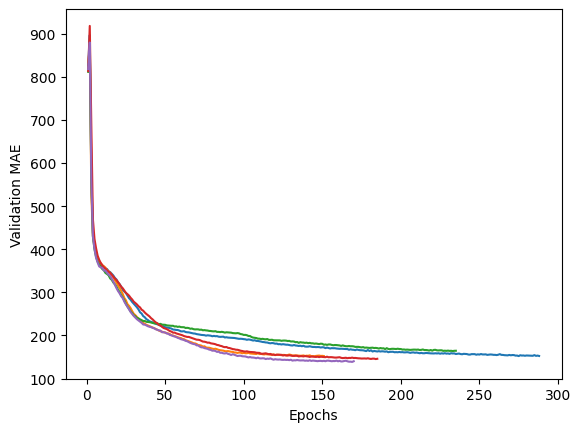

Hyperparameters: {'layer_nodes': [32, 16, 16], 'learning_rate': 0.001, 'dropout': 0, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


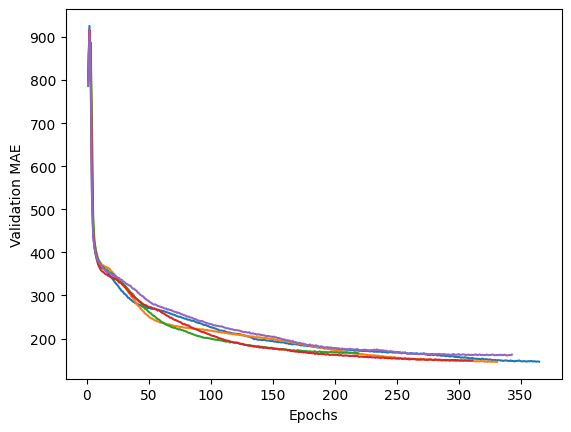

Hyperparameters: {'layer_nodes': [64, 32], 'learning_rate': 0.001, 'dropout': 0, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


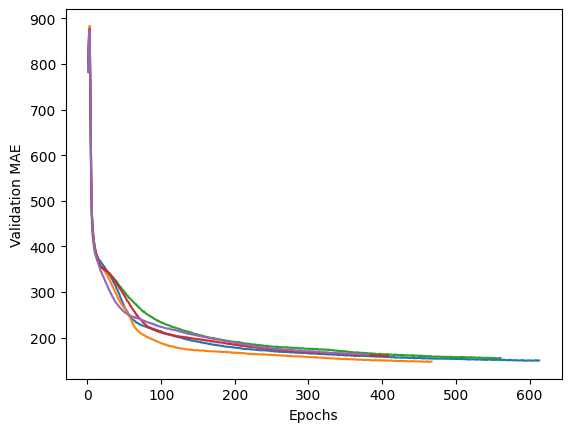

Hyperparameters: {'layer_nodes': [32, 16], 'learning_rate': 0.001, 'dropout': 0, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


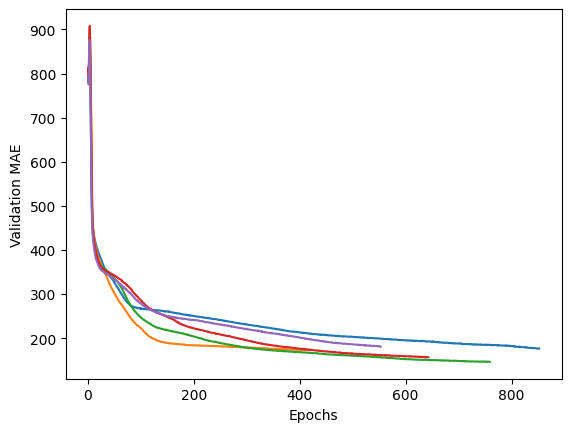

Hyperparameters: {'layer_nodes': [16, 8], 'learning_rate': 0.001, 'dropout': 0, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


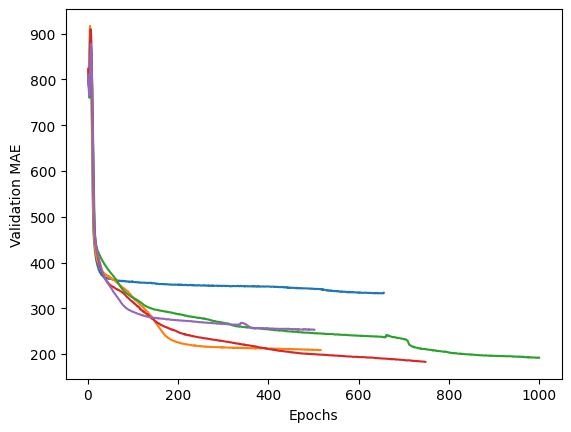

Hyperparameters: {'layer_nodes': [16], 'learning_rate': 0.001, 'dropout': 0, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/mean_squared_error/Reshape_1' defined at (most recent call last):
    File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/julialauten/git/aaa/.venv/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/julialauten/git/aaa/.venv/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/julialauten/git/aaa/.venv/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/Users/julialauten/git/aaa/.venv/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/julialauten/git/aaa/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/Users/julialauten/git/aaa/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/Users/julialauten/git/aaa/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/Users/julialauten/git/aaa/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/julialauten/git/aaa/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/julialauten/git/aaa/.venv/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/julialauten/git/aaa/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/Users/julialauten/git/aaa/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/Users/julialauten/git/aaa/.venv/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/julialauten/git/aaa/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/julialauten/git/aaa/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/julialauten/git/aaa/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/9w/zlqt6v1d55l_8s4sn0v5hd2h0000gq/T/ipykernel_50975/815449467.py", line 53, in <module>
      val_mae, val_mse, mae_hist, mse_hist = k_fold_nn(
    File "/var/folders/9w/zlqt6v1d55l_8s4sn0v5hd2h0000gq/T/ipykernel_50975/1419268747.py", line 73, in k_fold_nn
      history = model.fit(
    File "/Users/julialauten/git/aaa/.venv/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/julialauten/git/aaa/.venv/lib/python3.9/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/julialauten/git/aaa/.venv/lib/python3.9/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/Users/julialauten/git/aaa/.venv/lib/python3.9/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/julialauten/git/aaa/.venv/lib/python3.9/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/Users/julialauten/git/aaa/.venv/lib/python3.9/site-packages/keras/src/engine/training.py", line 1084, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/Users/julialauten/git/aaa/.venv/lib/python3.9/site-packages/keras/src/optimizers/legacy/optimizer_v2.py", line 598, in minimize
      grads_and_vars = self._compute_gradients(
    File "/Users/julialauten/git/aaa/.venv/lib/python3.9/site-packages/keras/src/optimizers/legacy/optimizer_v2.py", line 656, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "/Users/julialauten/git/aaa/.venv/lib/python3.9/site-packages/keras/src/optimizers/legacy/optimizer_v2.py", line 532, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/mean_squared_error/Reshape_1'
Input to reshape is a tensor with 1 values, but the requested shape has 32
	 [[{{node gradient_tape/mean_squared_error/Reshape_1}}]] [Op:__inference_train_function_24505217]

In [6]:
hyperaparameters_list = [
    {
        'layer_nodes': [64, 32, 16],
        'learning_rate': 0.001,
        'dropout': 0,
        'activation': 'relu',
        'optimizer': RMSprop
    },
    {
        'layer_nodes': [32, 16, 16],
        'learning_rate': 0.001,
        'dropout': 0,
        'activation': 'relu',
        'optimizer': RMSprop
    },
    {
        'layer_nodes': [64, 32],
        'learning_rate': 0.001,
        'dropout': 0,
        'activation': 'relu',
        'optimizer': RMSprop
    },
    {
        'layer_nodes': [32, 16],
        'learning_rate': 0.001,
        'dropout': 0,
        'activation': 'relu',
        'optimizer': RMSprop
    },
    {
        'layer_nodes': [16, 8],
        'learning_rate': 0.001,
        'dropout': 0,
        'activation': 'relu',
        'optimizer': RMSprop
    }
]

results = []
ep = 1000
bs = 32
k = 5

for hyperparameters in hyperaparameters_list:
    print("Hyperparameters: {}".format(hyperparameters))
    val_mae, val_mse, mae_hist, mse_hist = k_fold_nn(
        X_train, 
        y_train, 
        k=k, 
        epochs=ep, 
        batch_size=bs,
        verbose=0,
        hyperparams=hyperparameters)

    mae_mean = np.mean(val_mae)
    mse_mean = np.mean(val_mse)

    for i in range(k):
        plt.plot(range(1, len(mae_hist[i]) + 1), mae_hist[i])
    plt.xlabel('Epochs')
    plt.ylabel('Validation MAE')
    plt.show()

    hyperparameters["epochs"] = ep
    hyperparameters["batch_size"] = bs
    hyperparameters["mae"] = mae_mean
    hyperparameters["mse"] = mse_mean
    results.append(hyperparameters)

In [7]:
results_4_h6_df = pd.DataFrame(results)
results_4_h6_df

,layer_nodes,learning_rate,dropout,activation,optimizer,epochs,batch_size,mae,mse
0,"[64, 32, 16]",0.001,0,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,154.332919,181032.412500
1,"[32, 16, 16]",0.001,0,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,156.417404,183814.112500
2,"[64, 32]",0.001,0,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,160.978400,195932.421875
3,"[32, 16]",0.001,0,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,172.175775,217171.462500
4,"[16, 8]",0.001,0,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,237.502542,364739.568750


We can see that the largest layer architecture yields the best results. Therefore, we test out even larger architectures.

Hyperparameters: {'layer_nodes': [64, 64, 32, 16], 'learning_rate': 0.001, 'dropout': 0, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


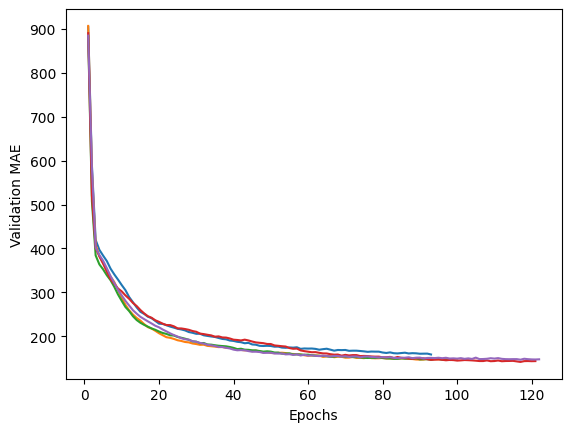

Hyperparameters: {'layer_nodes': [64, 32, 16, 8], 'learning_rate': 0.001, 'dropout': 0, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


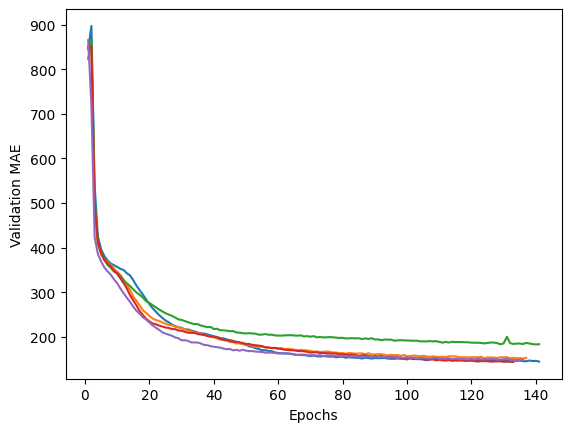

Hyperparameters: {'layer_nodes': [32, 16, 8], 'learning_rate': 0.001, 'dropout': 0, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


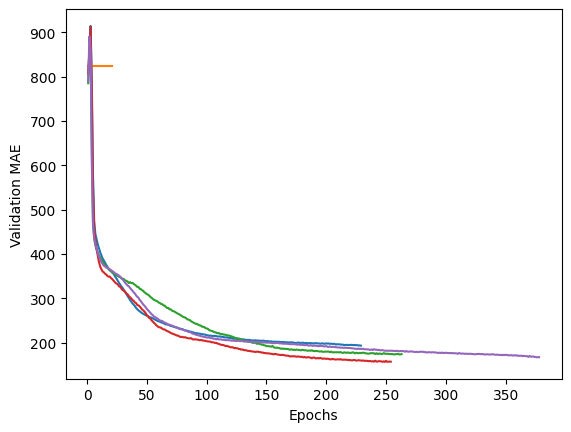

In [9]:
hyperaparameters_list = [
    {
        'layer_nodes': [64, 64, 32, 16],
        'learning_rate': 0.001,
        'dropout': 0,
        'activation': 'relu',
        'optimizer': RMSprop
    },
     {
        'layer_nodes': [64, 32, 16, 8],
        'learning_rate': 0.001,
        'dropout': 0,
        'activation': 'relu',
        'optimizer': RMSprop
    },
     {
        'layer_nodes': [32, 16, 8],
        'learning_rate': 0.001,
        'dropout': 0,
        'activation': 'relu',
        'optimizer': RMSprop
    },
]

results = []
ep = 1000
bs = 32
k = 5

for hyperparameters in hyperaparameters_list:
    print("Hyperparameters: {}".format(hyperparameters))
    val_mae, val_mse, mae_hist, mse_hist = k_fold_nn(
        X_train, 
        y_train, 
        k=k, 
        epochs=ep, 
        batch_size=bs,
        verbose=0,
        hyperparams=hyperparameters)

    mae_mean = np.mean(val_mae)
    mse_mean = np.mean(val_mse)

    for i in range(k):
        plt.plot(range(1, len(mae_hist[i]) + 1), mae_hist[i])
    plt.xlabel('Epochs')
    plt.ylabel('Validation MAE')
    plt.show()

    hyperparameters["epochs"] = ep
    hyperparameters["batch_size"] = bs
    hyperparameters["mae"] = mae_mean
    hyperparameters["mse"] = mse_mean
    results.append(hyperparameters)

In [10]:
results_4_h6_df = pd.DataFrame(results)
results_4_h6_df

,layer_nodes,learning_rate,dropout,activation,optimizer,epochs,batch_size,mae,mse
0,"[64, 64, 32, 16]",0.001,0,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,149.733167,1.772377e+05
1,"[64, 32, 16, 8]",0.001,0,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,154.823318,1.853243e+05
2,"[32, 16, 8]",0.001,0,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,302.049005,1.117240e+06


We observe that the largest model with a 64-64-32-16 layer architecture has the best results. Now we want to test out different learning rates and dropout values to regularize the model.

### Learning Rate and Dropout

Hyperparameters: {'layer_nodes': [64, 64, 32, 16], 'learning_rate': 0.01, 'dropout': 0, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


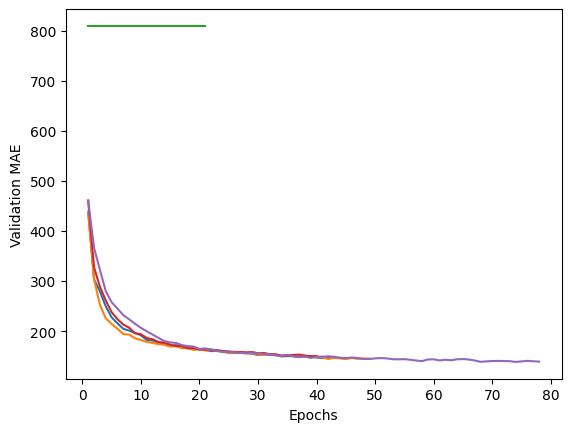

Hyperparameters: {'layer_nodes': [64, 64, 32, 16], 'learning_rate': 0.1, 'dropout': 0, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


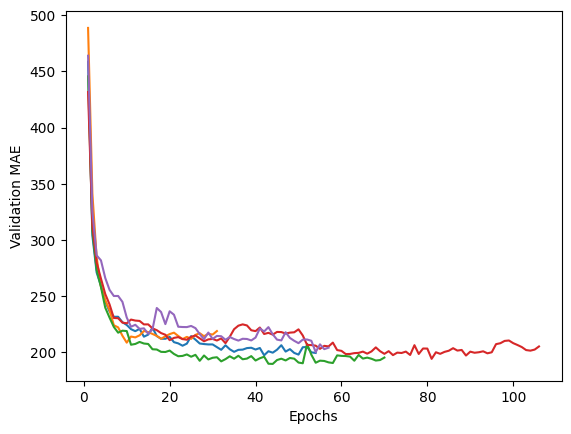

Hyperparameters: {'layer_nodes': [64, 64, 32, 16], 'learning_rate': 0.0001, 'dropout': 0, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


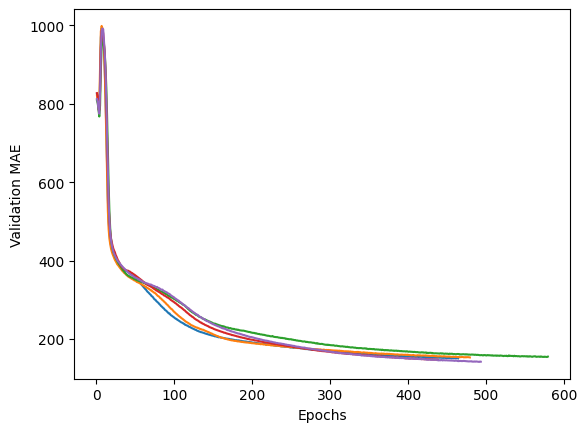

Hyperparameters: {'layer_nodes': [64, 64, 32, 16], 'learning_rate': 0.001, 'dropout': 0.01, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


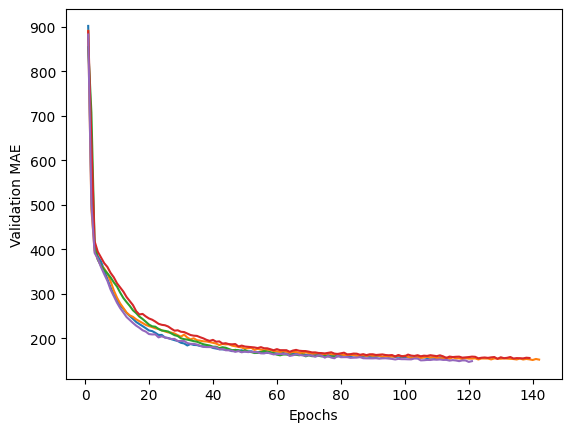

Hyperparameters: {'layer_nodes': [64, 64, 32, 16], 'learning_rate': 0.001, 'dropout': 0.1, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


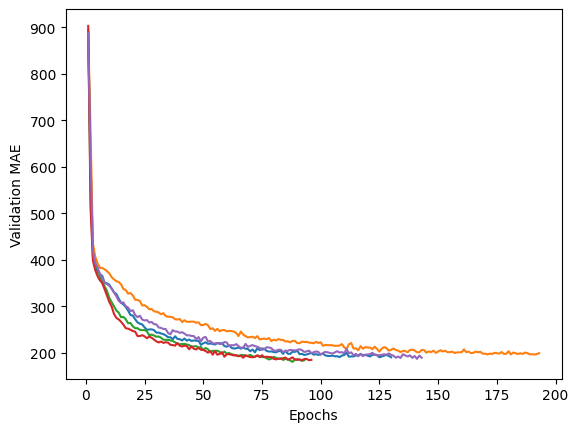

In [11]:
hyperaparameters_list = [
    {
        'layer_nodes': [64, 64, 32, 16],
        'learning_rate': 0.01,
        'dropout': 0,
        'activation': 'relu',
        'optimizer': RMSprop
    },
    {
        'layer_nodes': [64, 64, 32, 16],
        'learning_rate': 0.1,
        'dropout': 0,
        'activation': 'relu',
        'optimizer': RMSprop
    },
    {
        'layer_nodes': [64, 64, 32, 16],
        'learning_rate': 0.0001,
        'dropout': 0,
        'activation': 'relu',
        'optimizer': RMSprop
    },
    {
        'layer_nodes': [64, 64, 32, 16],
        'learning_rate': 0.001,
        'dropout': 0.01,
        'activation': 'relu',
        'optimizer': RMSprop
    },
    {
        'layer_nodes': [64, 64, 32, 16],
        'learning_rate': 0.001,
        'dropout': 0.1,
        'activation': 'relu',
        'optimizer': RMSprop
    },
]

results_lr_do = []
ep = 1000
bs = 32
k = 5

for hyperparameters in hyperaparameters_list:
    print("Hyperparameters: {}".format(hyperparameters))
    val_mae, val_mse, mae_hist, mse_hist = k_fold_nn(
        X_train, 
        y_train, 
        k=k, 
        epochs=ep, 
        batch_size=bs,
        verbose=0,
        hyperparams=hyperparameters)

    mae_mean = np.mean(val_mae)
    mse_mean = np.mean(val_mse)

    for i in range(k):
        plt.plot(range(1, len(mae_hist[i]) + 1), mae_hist[i])
    plt.xlabel('Epochs')
    plt.ylabel('Validation MAE')
    plt.show()

    hyperparameters["epochs"] = ep
    hyperparameters["batch_size"] = bs
    hyperparameters["mae"] = mae_mean
    hyperparameters["mse"] = mse_mean
    results_lr_do.append(hyperparameters)

In [15]:
results_4_h6_df = pd.concat([results_4_h6_df, pd.DataFrame(results_lr_do)], axis=0)
results_4_h6_df


,layer_nodes,learning_rate,dropout,activation,optimizer,epochs,batch_size,mae,mse
0,"[64, 64, 32, 16]",0.0010,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,149.733167,1.772377e+05
1,"[64, 32, 16, 8]",0.0010,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,154.823318,1.853243e+05
2,"[32, 16, 8]",0.0010,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,302.049005,1.117240e+06
0,"[64, 64, 32, 16]",0.0100,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,288.312869,1.161627e+06
1,"[64, 64, 32, 16]",0.1000,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,176.810608,1.943076e+05
2,"[64, 64, 32, 16]",0.0001,0.00,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,155.943332,1.840256e+05
3,"[64, 64, 32, 16]",0.0010,0.01,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,146.809146,1.726223e+05
4,"[64, 64, 32, 16]",0.0010,0.10,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,150.006729,1.844500e+05


In this table we can see that the same learning rate as before (0.001) and a slight dropout of 0.01 gets to a slightly lower mae. We try with an even lower dropout.

Hyperparameters: {'layer_nodes': [64, 64, 32, 16], 'learning_rate': 0.001, 'dropout': 0.001, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


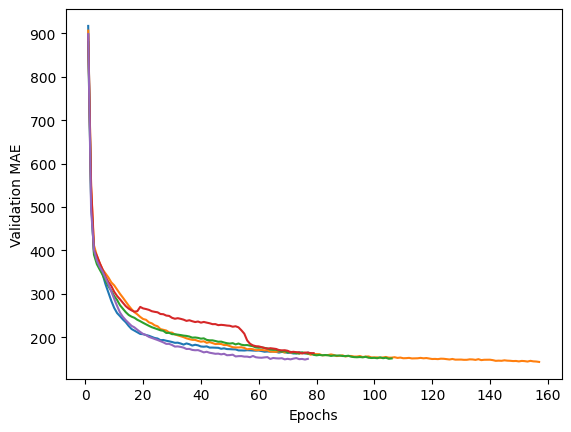

Hyperparameters: {'layer_nodes': [64, 64, 32, 16], 'learning_rate': 0.001, 'dropout': 0.0001, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


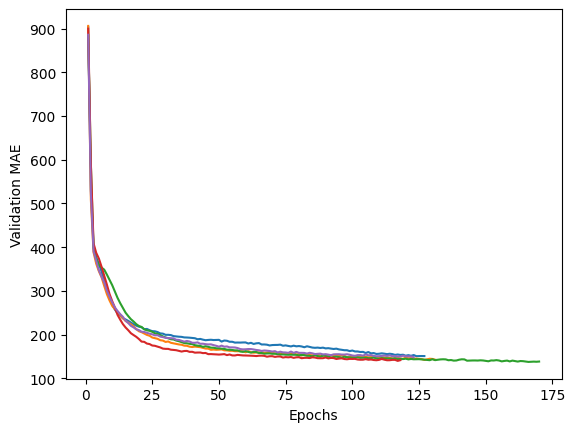

In [17]:
hyperaparameters_list = [
    {
        'layer_nodes': [64, 64, 32, 16],
        'learning_rate': 0.001,
        'dropout': 0.001,
        'activation': 'relu',
        'optimizer': RMSprop
    },
    {
        'layer_nodes': [64, 64, 32, 16],
        'learning_rate': 0.001,
        'dropout': 0.0001,
        'activation': 'relu',
        'optimizer': RMSprop
    }
]

results_lr_do = []
ep = 1000
bs = 32
k = 5

for hyperparameters in hyperaparameters_list:
    print("Hyperparameters: {}".format(hyperparameters))
    val_mae, val_mse, mae_hist, mse_hist = k_fold_nn(
        X_train, 
        y_train, 
        k=k, 
        epochs=ep, 
        batch_size=bs,
        verbose=0,
        hyperparams=hyperparameters)

    mae_mean = np.mean(val_mae)
    mse_mean = np.mean(val_mse)

    for i in range(k):
        plt.plot(range(1, len(mae_hist[i]) + 1), mae_hist[i])
    plt.xlabel('Epochs')
    plt.ylabel('Validation MAE')
    plt.show()

    hyperparameters["epochs"] = ep
    hyperparameters["batch_size"] = bs
    hyperparameters["mae"] = mae_mean
    hyperparameters["mse"] = mse_mean
    results_lr_do.append(hyperparameters)

In [18]:
results_4_h6_df = pd.concat([results_4_h6_df, pd.DataFrame(results_lr_do)], axis=0)
results_4_h6_df

,layer_nodes,learning_rate,dropout,activation,optimizer,epochs,batch_size,mae,mse
0,"[64, 64, 32, 16]",0.0010,0.0000,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,149.733167,1.772377e+05
1,"[64, 32, 16, 8]",0.0010,0.0000,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,154.823318,1.853243e+05
2,"[32, 16, 8]",0.0010,0.0000,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,302.049005,1.117240e+06
0,"[64, 64, 32, 16]",0.0100,0.0000,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,288.312869,1.161627e+06
1,"[64, 64, 32, 16]",0.1000,0.0000,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,176.810608,1.943076e+05
2,"[64, 64, 32, 16]",0.0001,0.0000,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,155.943332,1.840256e+05
3,"[64, 64, 32, 16]",0.0010,0.0100,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,146.809146,1.726223e+05
4,"[64, 64, 32, 16]",0.0010,0.1000,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,150.006729,1.844500e+05
0,"[64, 64, 32, 16]",0.0010,0.0010,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,157.428543,1.873643e+05
1,"[64, 64, 32, 16]",0.0010,0.0001,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,148.568777,1.717530e+05


learning rate 0.001 and dropout 0.01 seem to be the best option.

### Activation

Now we test the activation function within the hidden layers, whether relu or sigmoid works better. For the output node we use Relu to eliminate negative values.

Hyperparameters: {'layer_nodes': [64, 64, 32, 16], 'learning_rate': 0.001, 'dropout': 0.01, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


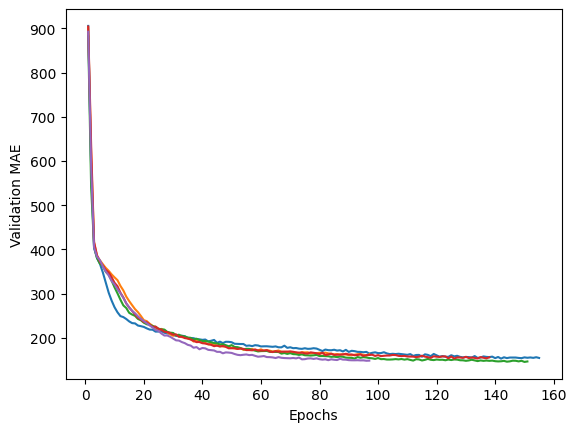

Hyperparameters: {'layer_nodes': [64, 64, 32, 16], 'learning_rate': 0.001, 'dropout': 0.01, 'activation': 'sigmoid', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


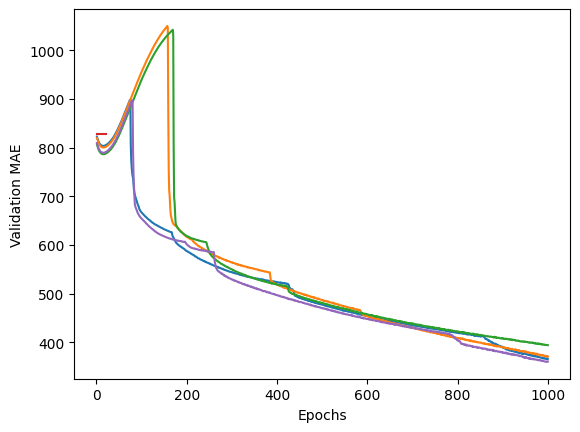

In [20]:
hyperaparameters_list = [
    {
        'layer_nodes': [64, 64, 32, 16],
        'learning_rate': 0.001,
        'dropout': 0.01,
        'activation': 'relu',
        'optimizer': RMSprop
    },
    {
        'layer_nodes': [64, 64, 32, 16],
        'learning_rate': 0.001,
        'dropout': 0.01,
        'activation': 'sigmoid',
        'optimizer': RMSprop
    },
]

results_activation = []
ep = 1000
bs = 32
k = 5

for hyperparameters in hyperaparameters_list:
    print("Hyperparameters: {}".format(hyperparameters))
    val_mae, val_mse, mae_hist, mse_hist = k_fold_nn(
        X_train, 
        y_train, 
        k=k, 
        epochs=ep, 
        batch_size=bs,
        verbose=0,
        hyperparams=hyperparameters)

    mae_mean = np.mean(val_mae)
    mse_mean = np.mean(val_mse)

    for i in range(k):
        plt.plot(range(1, len(mae_hist[i]) + 1), mae_hist[i])
    plt.xlabel('Epochs')
    plt.ylabel('Validation MAE')
    plt.show()

    hyperparameters["epochs"] = ep
    hyperparameters["batch_size"] = bs
    hyperparameters["mae"] = mae_mean
    hyperparameters["mse"] = mse_mean
    results_activation.append(hyperparameters)

In [21]:
results_4_h6_df = pd.concat([results_4_h6_df, pd.DataFrame(results_activation)], axis=0)
results_4_h6_df

,layer_nodes,learning_rate,dropout,activation,optimizer,epochs,batch_size,mae,mse
0,"[64, 64, 32, 16]",0.0010,0.0000,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,149.733167,1.772377e+05
1,"[64, 32, 16, 8]",0.0010,0.0000,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,154.823318,1.853243e+05
2,"[32, 16, 8]",0.0010,0.0000,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,302.049005,1.117240e+06
0,"[64, 64, 32, 16]",0.0100,0.0000,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,288.312869,1.161627e+06
1,"[64, 64, 32, 16]",0.1000,0.0000,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,176.810608,1.943076e+05
2,"[64, 64, 32, 16]",0.0001,0.0000,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,155.943332,1.840256e+05
3,"[64, 64, 32, 16]",0.0010,0.0100,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,146.809146,1.726223e+05
4,"[64, 64, 32, 16]",0.0010,0.1000,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,150.006729,1.844500e+05
0,"[64, 64, 32, 16]",0.0010,0.0010,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,157.428543,1.873643e+05
1,"[64, 64, 32, 16]",0.0010,0.0001,relu,<class 'keras.src.optimizers.legacy.rmsprop.RM...,1000,32,148.568777,1.717530e+05


Sigmoid performs way worse than relu so we keep relu as our activation function in the hidden layers.

### Batch Size

Hyperparameters: {'layer_nodes': [64, 64, 32, 16], 'learning_rate': 0.001, 'dropout': 0.01, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


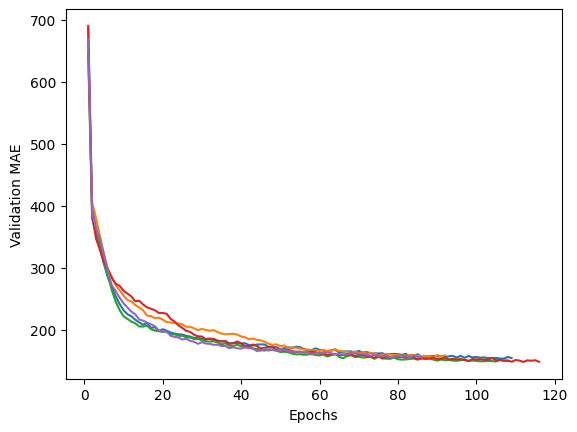

Hyperparameters: {'layer_nodes': [64, 64, 32, 16], 'learning_rate': 0.001, 'dropout': 0.01, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>, 'epochs': 1000, 'batch_size': 8, 'mae': 142.4907440185547, 'mse': 167738.40625}
processing fold # 0  of  5
processing fold # 1  of  5
processing fold # 2  of  5
processing fold # 3  of  5
processing fold # 4  of  5


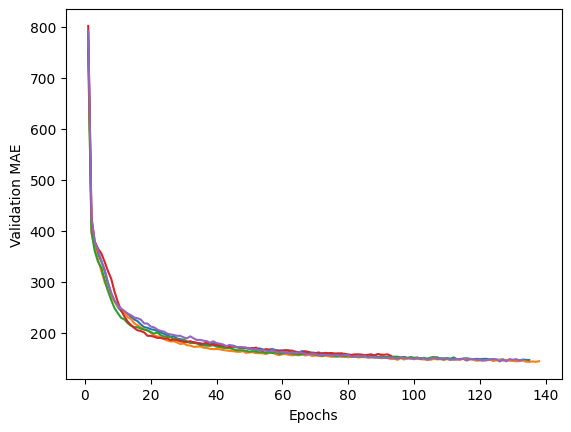

Hyperparameters: {'layer_nodes': [64, 64, 32, 16], 'learning_rate': 0.001, 'dropout': 0.01, 'activation': 'relu', 'optimizer': <class 'keras.src.optimizers.legacy.rmsprop.RMSprop'>, 'epochs': 1000, 'batch_size': 16, 'mae': 141.1643829345703, 'mse': 170394.59375}
processing fold # 0  of  5


In [22]:
hyperaparameters_list = [
    {
        'layer_nodes': [64, 64, 32, 16],
        'learning_rate': 0.001,
        'dropout': 0.01,
        'activation': 'relu',
        'optimizer': RMSprop
    },
]

results_bs = []
ep = 1000
k = 5

for bs in [8, 16, 32, 64, 128]:
    for hyperparameters in hyperaparameters_list:
        print("Hyperparameters: {}".format(hyperparameters))
        val_mae, val_mse, mae_hist, mse_hist = k_fold_nn(
            X_train, 
            y_train, 
            k=k, 
            epochs=ep, 
            batch_size=bs,
            verbose=0,
            hyperparams=hyperparameters)

        mae_mean = np.mean(val_mae)
        mse_mean = np.mean(val_mse)

        for i in range(k):
            plt.plot(range(1, len(mae_hist[i]) + 1), mae_hist[i])
        plt.xlabel('Epochs')
        plt.ylabel('Validation MAE')
        plt.show()

        hyperparameters["epochs"] = ep
        hyperparameters["batch_size"] = bs
        hyperparameters["mae"] = mae_mean
        hyperparameters["mse"] = mse_mean
        results_bs.append(hyperparameters)

In [ ]:
results_4_h6_df = pd.concat([results_4_h6_df, pd.DataFrame(results_bs)], axis=0)
results_4_h6_df

## All Time and Location resolutions

In [ ]:
hyperaparameters = {
        'layer_nodes': [64, 64, 32, 16],
        'learning_rate': 0.001,
        'dropout': 0.01,
        'activation': 'relu',
        'optimizer': RMSprop
    }

In [ ]:
results_sampled = []

for time_bucket_length in [1, 2, 4, 6, 24]:
    for location_bucket in ["h3_05", "h3_06", "h3_07", "h3_08", "h3_09", "centroid"]:

        print(f"Time bucket length: {time_bucket_length}h")
        print(f"Location bucket: {location_bucket}")

        # read in data
        data = pd.read_parquet(f"../../data/predictive/Taxi_Trips_Spatio_Temporal_{time_bucket_length}_{location_bucket}.parquet")
        print(data.shape)

        # create sample from data with 30 hexagons
        #sampled_hexagons =  random.sample(data[location_bucket].unique().tolist(), 30) # sample data to 30 hexagons
        #data_sampled = data[data[location_bucket].isin(sampled_hexagons)]
        #print(data_sampled.shape)
        #if data_sampled.shape[0] >= 50000: # sample data to 50000 rows
        #    data_sampled = data_sampled.sample(50000, random_state=4711)
        #    print(data_sampled.shape)
        data_sampled = data
        
        # scale data and create one hot encoding for location bucket feature
        scaled_data = scale_data_and_get_dummies(data_sampled, location_bucket)
        print(scaled_data.shape)

        # split data into train and test
        X_train, X_test, y_train, y_test = split_train_test(scaled_data)

         model = build_model(
            X_train,
            layer_nodes=hyperaparameters["layer_nodes"],
            learning_rate=hyperaparameters["learning_rate"],
            dropout=hyperaparameters["dropout"],
            activation=hyperaparameters["activation"],
            optimizer=hyperaparameters["optimizer"])
        
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=20, 
            min_delta=y_train.std()*0.1, 
            restore_best_weights=True)

        model.fit(
            X_train,
            y_train,
            validation_data=(X_test, y_test),
            epochs=1000,
            batch_size=batch_size,
            verbose=verbose,
            callbacks=[early_stop]
            )

        # evaluate metrics
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(2)
        mape = mean_absolute_percentage_error(y_test, y_pred).round(2)
        mse = mean_squared_error(y_test, y_pred).round(2)
        r2 = r2_score(y_test, y_pred).round(4)

        # save best params and metrics
        results_sampled.append({
            "time_bucket_length": time_bucket_length,
            "location_bucket": location_bucket,
            "mae": mae,
            "mape": mape,
            "mse": mse,
            "r2": r2
        })
        
        print()

In [ ]:
hyperaparams = hyperaparameters
# Evaluating the Model with the Test Set
model = build_model(X_train,
                    layer_nodes=hyperaparams["layer_nodes"],
                    learning_rate=hyperaparams["learning_rate"],
                    dropout=hyperaparams["dropout"],
                    activation=hyperaparams["activation"],
                    optimizer=hyperaparams["optimizer"])
model.fit(X_train, y_train, epochs=80, batch_size=64, verbose=0)
test_mse_score, test_mae_score = model.evaluate(X_test, y_test)

61/61 [==============================] - 0s 495us/step - loss: 99316.4297 - mae: 116.8060


In [ ]:
# Voila.
test_mae_score

116.80601501464844

In [5]:
# create sample from data with 10 hexagons
sampled_hexagons =  random.sample(data[location_bucket].unique().tolist(), 30)
data_sampled = data[data[location_bucket].isin(sampled_hexagons)]
print(data_sampled.shape)
if data_sampled.shape[0] >= 50000:
    data_sampled = data_sampled.sample(50000, random_state=4711)
    print(data_sampled.shape)

data_sampled = data

# scale data and create one hot encoding for location bucket feature
scaled_data = scale_data_and_get_dummies(data_sampled, location_bucket)
print(scaled_data.shape)

# split data into train and test
X_train, X_test, y_train, y_test = split_train_test(scaled_data)

(9573, 13)
